Logistic Regression is a supervised machine learning algorithm for classification. Unlike linear regression which aims to predict an output from an input, it aims to predict the probability of belonging to a class based on inputs. Using the sigmoid function it maps the values to between 0 and 1, and decides based on the decision boundary (usually 0.5) whether they belong to a class or not.

The sigmoid funtcion is:


$\sigma(z) = \frac{1}{1+e^{-z}}$

where $z$ is the logits matrix (feature matrix (X) * weights vector (w))

In [1]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

As with any prediction, we want to maximise the likelihood of predicting the correct value; or in other words minimise our loss through training. In logistic regression we want to minimise cross-entropy loss. This is defined as:

$
L(\mathbf{w})=  \frac{1}{n}\sum_{i=1}^n -{y^{(i)}} \ln \sigma^{(i)}- (1- y^{(i)}) \ln (1-\sigma^{(i)})
$

Or in english: the mean of the negative true value multiplied by the log of the predicted value.

where true value = $y$ and predicted value = $\sigma^{(i)} =\sigma(\mathbf{w}^\top\mathbf{x}^{(i)} + b) = \frac{1}{1 + e^{-(\mathbf{w}^\top \mathbf{x}^{(i)} + b)}}$

The first half of the equation handles when the true value is 1($-{y^{(i)}} \ln \sigma^{(i)}$). And the second half $- (1- y^{(i)}) \ln (1-\sigma^{(i)})$ handles when the true value is 0.

When minimising the cross-entropy loss with gradient descent the model has the tendency to assign large weights to the training data, meaning it overfits and is sensitive to small changes in the inputs. To overcome this we add a regularisation term to the loss that is defined as the penalty term divided by two ($\frac{\lambda}{2}$), multiplied by the sqaured weights ($\mathbf{w}^\top\mathbf{w}
$).

$
L(\mathbf{w})=  \frac{1}{n}\sum_{i=1}^n -{y^{(i)}} \ln \sigma^{(i)}- (1- y^{(i)}) \ln (1-\sigma^{(i)}) + \frac{\lambda}{2} \mathbf{w}^\top\mathbf{w}
$

In [8]:
def cross_entropy_loss(w, X, y):
    z = X @ w
    y_hat = sigmoid(z)
    loss = np.mean(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
    # L2 regualisation added in GD
    return loss

If we run multiple combinations of weights we can plot the results and see which weights are optimal to minimise loss. This is obviously not an efficient way of optimising our weights, but allows us to picture the loss plane and understand what gradient descent is. After making a prediction of new weigths in training we compute the gradient, this points in the direction of the steepest increase, or when we take the negative, the steepest decrease in loss. Updating the weights using the gradient allows us to follow the plane (shown as the blue line below) to where the gradient reaches 0 / converges and loss is minimised. This iterative, educated update of the weights is much more effient than computing all possible combinations.  

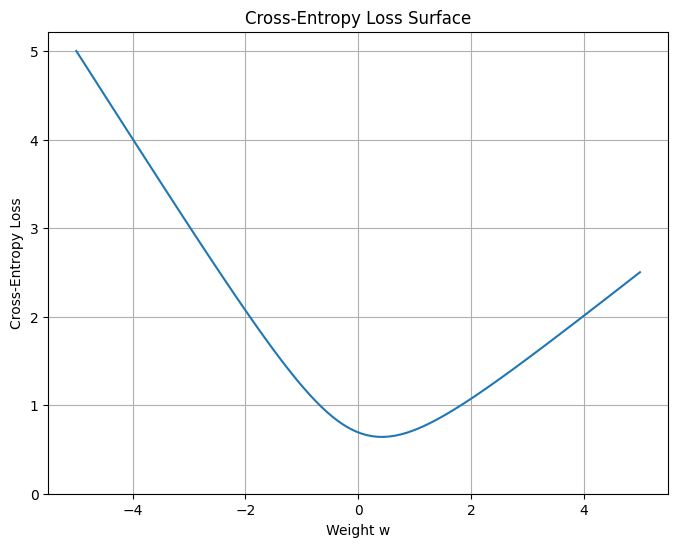

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data
X = np.array([1, 2])
Y = np.array([0, 1])

# Grid of weights
W = np.linspace(-5, 5, 100)
Loss = np.array([cross_entropy_loss(w, X, Y) for w in W])

# Plot 2D curve (1 weight)
plt.figure(figsize=(8,6))
plt.plot(W, Loss)
plt.xlabel('Weight w')
plt.ylabel('Cross-Entropy Loss')
plt.ylim(bottom=0)
plt.title('Cross-Entropy Loss Surface')
plt.grid(True)
plt.show()

The gradient for L2 regularised cross entropy loss is:

$\frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i) x_{ij} + \lambda w_j$

$\hat{y}_i$ = Predicted y

$y_i$ = Actual y

$x$ = input features

$\lambda w_j$ = Regularisation = lambda multiplied by weights

In [9]:
def gradient_ce_loss(w, X, y):
    z = X @ w
    y_hat = sigmoid(z)
    gradient = (X.T @ (y_hat-y)) / y.shape[0]
    return gradient

In this implementation I have used stochastic gredient descent as it is more efficient than the standard algorithm. This is because instead of calculating the gradient of all data points at the same time, it iteritively updates the weight using one data point (or a batch) and then again with the next point and so on - a data point is used once per pass.

    Psuedo code:
    for iteration in maximum iterations:
        shuffle data to avoid bias
        initialise weights
        for i in data:
            compute gradient
            update weights: w = w - learning_rate * gradient
        check convergence / compute total loss

In [10]:
def logistic_regression_reg_sgd_train(X, y, gamma, lam = 0.01, tol= 1e-4, maxIters= 10000):
    n, d = X.shape
    # initialise w0
    w0 = np.zeros(d)
    losses = []
    # loop until converge
    for iter in range(maxIters):
        # Shuffle dataset
        indicies = np.arange(n)
        np.random.shuffle(indicies)
        X_shuffled = X[indicies]
        y_shuffled = y[indicies]
        # Create copy to check for covergence at the end of each iteration
        w_old = w0.copy()
        for i in indicies:
        # for each observation (x^i, y^i) in (X, Y)
            x_i = X_shuffled[i].reshape(1, -1)
            y_i = np.array([y_shuffled[i]])
            # Compute gradient
            gradient = gradient_ce_loss(w0, x_i, y_i)
            # Regularization of gradient excluding bias
            gradient[1:] += lam * w0[1:]
            # Apply gradient descent
            gamma_decay = gamma / (1 + n * iter)
            w_new = w0 - gamma * gradient
            w0 = w_new

        loss = cross_entropy_loss(w0, X, y)
        losses.append(loss)
        if np.linalg.norm(w0 - w_old) < tol:
            break

    return w0, losses

After training we make predictions using the learnt weight parameters and the sigmoid function discussed earlier. We again compute loss to measure performance, but in prediction no regularisation is needed.

In [11]:
def predict_logistic_regression(w, X, y, threshold = 0.5, lam = 0.03):
    n, d = X.shape
    z = X @ w
    y_hat = sigmoid(z)
    predictions = (y_hat >= threshold).astype(int)
    loss = cross_entropy_loss(w, X, y)
    # Regularisation only needed in training
    return predictions, loss

In [12]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, centers=2, n_features=2, random_state=42)
X = np.column_stack((np.ones(X.shape[0]), X)) # Add column of ones for bias term

train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [14]:
learned_weights, training_loss = logistic_regression_reg_sgd_train(X_train, y_train, gamma=0.01, lam=0.03)
print(f"training loss: {training_loss[-1]}")

training loss: 0.008142530187766015


test loss: 0.009359817610304473


<function matplotlib.pyplot.show(close=None, block=None)>

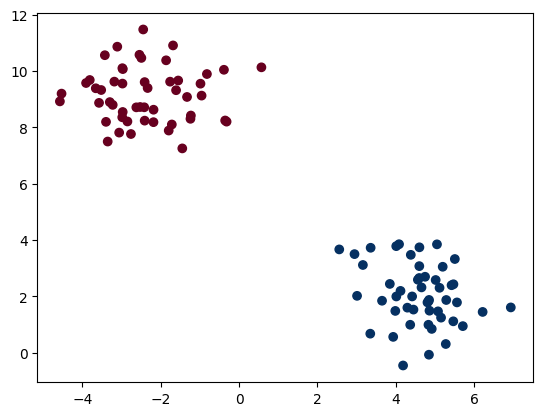

In [17]:
import matplotlib.pyplot as plt

predictions, test_loss = predict_logistic_regression(learned_weights, X_test, y_test)
print(f"test loss: {test_loss}")

plt.scatter(X_test[:, 1], X_test[:, 2], c=predictions, cmap='RdBu')
plt.show

###Bayesian Approach

The above implementation of Logistic Regression follows a frequentist view of the models weights. That is that the weights have a true, but unknown, value that we are trying to get as close as possible to. As the true value is unknown, we can never be sure how close we are to it and thus can't model uncertainty.

While accuracy tells us how close our model performed on past data, being able to quantify uncertainty is advantageous as we understand how much to trust our model on future data. To do this we can take a different apporach to Logistic Regression using a Bayesian view. This is that the weights are not fixed but a distribution. We can then give a weighted average prediction based on the weights across this distribution, with the prediction being high confidence if most classes agree on the classification.

Bayesian says the posterior (our new prediction of the distribution) is the prior (what we thought before) plus the likelihood (how well a particular weight choice explains the data).

Written mathmatically as:
log prior = $$
\ln p(\mathbf{w} \mid \lambda) = -\frac{\lambda}{2} \sum_{j=1}^m w_j^2
$$

log likelihood logistic =  $$
\sum_{i=1}^{n} \left[ y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln(1 - \sigma^{(i)}) \right]
$$

log posterior = $$
\ln p(\mathbf{w}|\{y^{(i)}\},\mathbf{X}) = -\frac{\lambda}{2} \sum w_j^2 + \sum_{i=1}^{n} \left[ y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln(1 - \sigma^{(i)}) \right] + c
$$

In [18]:
def log_likelihood(w, X, y):
    z = X @ w.T
    sigmoid = 1 / (1 + np.exp(-z))
    log_likelihood = np.sum(y * np.log(sigmoid) + ((1 - y) * np.log(1 - sigmoid)))
    return log_likelihood

def log_posterior(w, X, y, lambda0=1e-2):
    log_prior = -lambda0/2 * np.sum(w**2)
    log_like = log_likelihood(w, X, y)
    log_posterior = log_prior + log_like
    return log_posterior

Computing the full posterior distribution is usually intractable. We therefore use Markov Chain Monte Carlo (MCMC) algorithms to sample from the weight space. At each step, a new set of weights is randomly proposed. The proposal is accepted with probability equal to the ratio of the new posterior to the current posterior:

* If this ratio is ≥ 1, we always accept the new weights, which ensures we spend more time in high-probability regions.

* If the ratio is < 1, we accept the new weights at random, allowing occasional moves into lower-probability regions to explore the entire posterior.

This procedure produces a sequence of samples that approximates the posterior distribution.

The proposal distribution is from where the algorithm will take suggestions for weights. For Logistic Regression this is defined as:

$q(\mathbf{w}'|\mathbf{w}) = \mathcal{N}\left (\mathbf{w}, \left(\lambda \mathbf{I} + \frac{6}{\pi^2} \mathbf X^\top \mathbf X\right)^{-1}\right)$

Where $w$ is the current location and $\left(\lambda \mathbf{I} + \frac{6}{\pi^2} \mathbf X^\top \mathbf X\right)^{-1}$ the space in either directly where the next proposal can be taken from.



In [20]:
def metropolis_bayes_logistic_reg(X, y, lambda0=1e-2, mc=5000, burnin=1000):
    n, d = X.shape
    cov = np.linalg.inv(lambda0 * np.eye(d) + 6 / np.pi**2 * X.T @ X)
    w_samples = []
    w_current = np.zeros(d)
    log_posterior_current = log_posterior(w_current, X, y, lambda0)

    for m in range(mc + burnin):
        # propose a single new candidate
        w_proposal = np.random.multivariate_normal(w_current, cov)
        # Compute log posterior of proposed new sample
        log_posterior_proposal = log_posterior(w_proposal, X, y, lambda0)
        acceptance_prob = min(1, np.exp(log_posterior_proposal - log_posterior_current))
        # np.random.rand() is always between 0 and 1, so 1 is always accepted but gives chances of lower ratios to be accepted at random
        if np.random.rand() < acceptance_prob:
            w_current = w_proposal
            log_posterior_current = log_posterior_proposal

        if m >= burnin:
            w_samples.append(w_current)

    return w_samples

In [21]:
# Gather samples from data using MCMC
wsample = metropolis_bayes_logistic_reg(X, y)

In [22]:
# Predict mean classfication (the probability) across weight samples
def prediction_mc(xtest, wsamples):
    wsamples = np.array(wsamples)
    z = xtest @ wsamples.T
    sigmoid = 1 / (1 + np.exp(-z))
    mean = np.mean(sigmoid, axis=1)
    return mean

It's good to understand what bayesian logistic regression is predicting by looking at a contour plot. To do this we create a grid of sample inputs (not weights) and compute their bayesian predictive probability with respect to our sampled weights.

In [23]:
# Create grid covering feature ranges
x1_min, x1_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
x2_min, x2_max = X[:,2].min() - 0.5, X[:,2].max() + 0.5

x1_range = np.linspace(x1_min, x1_max, 200)  # 200 points along x1
x2_range = np.linspace(x2_min, x2_max, 200)  # 200 points along x2
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Flatten grid to pass through regression
xtest = np.vstack([x1_grid.ravel(), x2_grid.ravel()]).T
xtest_with_intercept = np.hstack([np.ones((xtest.shape[0], 1)), xtest])

# Sample a subset of posterior weights - the function samples 5000 but we will take a sub sample of 1000
wsample = np.array(wsample)
M = 1000
indices = np.random.choice(wsample.shape[0], M, replace=False)
wsamples_mc = wsample[indices]

# Predict mean probabilities for each grid point
mean_predictions = prediction_mc(xtest_with_intercept, wsamples_mc)

# Reshape for contour plotting
Z = mean_predictions.reshape(x1_grid.shape)

The below a contour plot of the probability of being correctly classified as class 1 (blue). This example the probabilities are black and white, but with points closer to the decision boundary we could say class 1 with 60% confidence.

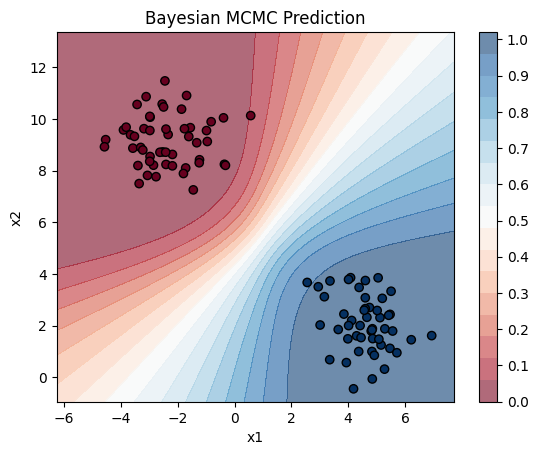

In [25]:
# Plot the contour for posterior predictive probabilities
cp = plt.contourf(x1_grid, x2_grid, Z, levels=18, cmap='RdBu', alpha=0.6)
cbar = plt.colorbar(cp)
cbar.set_ticks(np.arange(0, 1.1, 0.1))  # 0 to 1 inclusive

# Scatter points on top
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_test, cmap='RdBu', edgecolor='k', vmin=0, vmax=1)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Bayesian MCMC Prediction')
plt.show()